In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization
from sklearn.metrics import f1_score
from gensim.models import KeyedVectors
import gensim
import json
import warnings
import logging, sys
import os
from datetime import datetime
logging.disable(sys.maxsize)
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/sarthi/train_data.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/sarthi/valid_data.csv')
valid_data.drop('path', inplace=True, axis=1)
train_data.drop('path', inplace=True, axis=1)

In [4]:
# Checking Null value
train_data.isnull().any()
valid_data.isnull().any()

transcription    False
action           False
object           False
location         False
dtype: bool

In [5]:
# Finding out how many unique value train set have 
print(train_data['action'].unique(),train_data['object'].unique(), train_data['location'].unique(), sep = "\n\n")

['activate' 'increase' 'change language' 'decrease' 'deactivate' 'bring']

['lights' 'heat' 'Chinese' 'none' 'volume' 'English' 'lamp' 'shoes'
 'newspaper' 'socks' 'music' 'Korean' 'juice' 'German']

['kitchen' 'none' 'washroom' 'bedroom']


In [6]:
# Here we can use pd.Categorical(valid_data['action']) 

act_encoder = OneHotEncoder(sparse=False, dtype='int32', handle_unknown='ignore')
obj_encoder = OneHotEncoder(sparse=False, dtype='int32', handle_unknown='ignore')
loc_encoder = OneHotEncoder(sparse=False, dtype='int32', handle_unknown='ignore')

act_oh = act_encoder.fit_transform(np.array(train_data['action']).reshape(-1,1))
obj_oh = obj_encoder.fit_transform(np.array(train_data['object']).reshape(-1,1))
loc_oh = loc_encoder.fit_transform(np.array(train_data['location']).reshape(-1,1))
train_data['act'] = list(act_oh)
train_data['obj'] = list(obj_oh)
train_data['loc'] = list(loc_oh)
# train_data['class']=train_data['act_oh']
# for i in range(len(train_data)):
#   train_data['class'].iloc[i]= list(train_data['act_oh'].iloc[i])+list(train_data['obj_oh'].iloc[i])+list(train_data['loc_oh'].iloc[i])

train_data.head()

,transcription,action,object,location,act,obj,loc
0,Turn on the kitchen lights,activate,lights,kitchen,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0]"
1,Turn up the temperature,increase,heat,none,"[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
2,OK now switch the main language to Chinese,change language,Chinese,none,"[0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
3,Turn down the bathroom temperature,decrease,heat,washroom,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"
4,Change the language,change language,none,none,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0]"


In [7]:
# Using transcription 
import re
import unicodedata
import string
import spacy

nlp = spacy.load('en_core_web_sm')

def clean1(text, accented=True, special=True, punctuation = True):
  if accented:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  if punctuation:
    text = ''.join([c for c in text if c not in string.punctuation])
  if special:
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pat, '', text)
  return text.lower()
  
def stopword(text):
  # text = nlp(text)
  stopwords = nlp.Defaults.stop_words
  lst=[]
  for token in text.split():
      if token.lower() not in stopwords:    #checking whether the word is not 
          lst.append(token)                    #present in the stopword list.
  text = ' '.join(lst)
  return text

In [8]:
train_data['transcription'] = train_data['transcription'].apply(clean1)
valid_data['transcription'] = valid_data['transcription'].apply(stopword)
train_data['transcription'] = train_data['transcription'].apply(stopword)
valid_data['transcription'] = valid_data['transcription'].apply(clean1)
train_data.head()
# valid_data.head()

,transcription,action,object,location,act,obj,loc
0,turn kitchen lights,activate,lights,kitchen,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0]"
1,turn temperature,increase,heat,none,"[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
2,ok switch main language chinese,change language,Chinese,none,"[0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
3,turn bathroom temperature,decrease,heat,washroom,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"
4,change language,change language,none,none,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0]"


In [9]:
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data['transcription'])
token_train = tokenizer.texts_to_sequences(train_data['transcription'])
token_valid = tokenizer.texts_to_sequences(valid_data['transcription'])
vocab_size = len(tokenizer.word_index) + 1

In [10]:
# As the length of arrays are diffrent we need to pad it
max_length = 200
train_data['padded_sequences'] = pad_sequences(token_train,  padding='post', maxlen=max_length).tolist()
train = np.array([np.array(i) for i in train_data['padded_sequences']])
valid_data['padded_sequences'] = pad_sequences(token_valid,  padding='post', maxlen=max_length).tolist()
valid = np.array([np.array(i) for i in train_data['padded_sequences']])

In [11]:
! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
!unzip "./wiki-news-300d-1M.vec.zip"

--2022-01-12 13:39:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  25.7MB/s    in 26s     

2022-01-12 13:39:52 (24.6 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  ./wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [12]:
from gensim.models import KeyedVectors
e_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    try:    
      embedding_vector = e_model[word]
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
    except:
      embedding_matrix[i] = np.zeros((300,))
      print(1)

In [13]:
# Treating [location,object,action] as class and training the model on them
t = pd.DataFrame()
t["all"] =train_data['act']
for i in range(len(train_data)):
  t['all'].iloc[i]= list(train_data['act'].iloc[i])+list(train_data['obj'].iloc[i])+list(train_data['loc'].iloc[i])
Y = pd.DataFrame()
for i in range(23):
  Y[i+1]=t['all'].apply(lambda x: int(x[i]))

In [14]:
# Taking X as the padded output of the tokenier
X = train

In [15]:
#seperating the data in test and train pair
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [16]:
#Model
EMBEDDING_DIM = 300
embedding_layer = Embedding(vocab_size,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=10,
        trainable=False)

lstm_layer_1 = LSTM(20, return_sequences=False, dropout=0.15, recurrent_dropout=0.15)

sequence_input = Input(shape=(200,), dtype='int32')
x1 = embedding_layer(sequence_input)
x1 = lstm_layer_1(x1)
x1 = Dropout(0.10)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(500, activation='relu')(x1)
x1 = Dropout(0.10)(x1)
x1 = Dense(50, activation='relu')(x1)
x1 = Dropout(0.10)(x1)
x1 = BatchNormalization()(x1)
preds = Dense(23, activation='softmax')(x1)

model = Model(inputs=sequence_input, outputs=preds)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          20700     
                                                                 
 lstm (LSTM)                 (None, 20)                25680     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 500)               10500     
                                                             

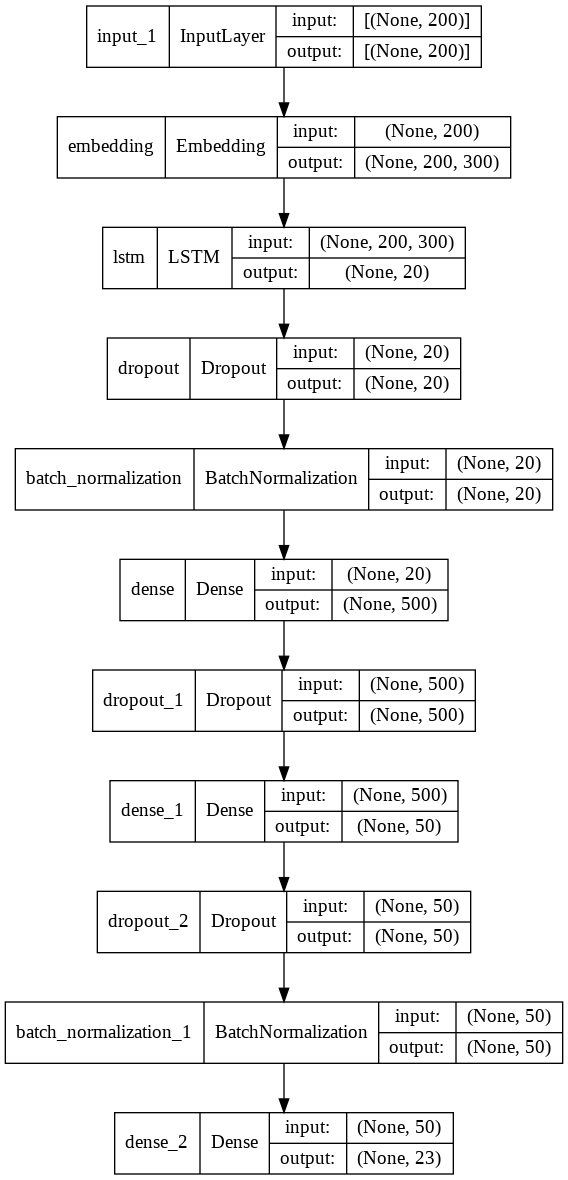

In [17]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [18]:
loss_fn = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_acc_metric = tf.keras.losses.MeanAbsoluteError()
val_acc_metric = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=train_acc_metric)
model.fit(X_train, y_train, batch_size=1024, epochs=100, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 38s 4s/step - loss: 0.1557 - mean_absolute_error: 0.1557 - val_loss: 0.1553 - val_mean_absolute_error: 0.1554
Epoch 2/100
8/8 [==============================] - 32s 4s/step - loss: 0.1484 - mean_absolute_error: 0.1480 - val_loss: 0.1548 - val_mean_absolute_error: 0.1548
Epoch 3/100
8/8 [==============================] - 33s 4s/step - loss: 0.1390 - mean_absolute_error: 0.1389 - val_loss: 0.1539 - val_mean_absolute_error: 0.1539
Epoch 4/100
8/8 [==============================] - 32s 4s/step - loss: 0.1348 - mean_absolute_error: 0.1347 - val_loss: 0.1531 - val_mean_absolute_error: 0.1531
Epoch 5/100
8/8 [==============================] - 32s 4s/step - loss: 0.1316 - mean_absolute_error: 0.1315 - val_loss: 0.1522 - val_mean_absolute_error: 0.1522
Epoch 6/100
8/8 [==============================] - 32s 4s/step - loss: 0.1296 - mean_absolute_error: 0.1295 - val_loss: 0.1512 - val_mean_absolute_error: 0.1513
Epoch 7/100
8/8 [=================

In [24]:
test_df= valid_data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_df['transcription'])

max_len = 200
data = tokenizer.texts_to_sequences(test_df['transcription'].values)
data = pad_sequences(data, maxlen=max_len)

preds = model.predict(data)
ans=preds
# print(ans)

test_df['act']=test_df['transcription']
test_df['obj']=test_df['transcription']
test_df['loc']=test_df['transcription']

for i in range(len(test_df)):
  temp=[]
  for j in range(6):
    temp.append(round(ans[i][j]))
  test_df['act'].iloc[i]= np.array(temp)

  temp=[]
  for j in range(4,18):
    temp.append(round(ans[i][j]))
  test_df['obj'].iloc[i]= np.array(temp)
  
  temp=[]
  for j in range(19,23):
    temp.append(round(ans[i][j]))
  test_df['loc'].iloc[i]= np.array(temp)

# print(test_df.head())

# test_df.head()

test_df['act_pred']= test_df['act'].apply(lambda x: act_encoder.inverse_transform(x.reshape(1,-1)))
test_df['obj_pred']= test_df['obj'].apply(lambda x: obj_encoder.inverse_transform(x.reshape(1,-1)))
test_df['loc_pred']= test_df['loc'].apply(lambda x: loc_encoder.inverse_transform(x.reshape(1,-1)))

test_df['act_pred']=test_df['act_pred'].apply(lambda x: x[0][0])
test_df['act_pred']=test_df['act_pred'].apply(lambda x: x if x else 'none')

test_df['obj_pred']=test_df['obj_pred'].apply(lambda x: x[0][0])
test_df['obj_pred']=test_df['obj_pred'].apply(lambda x: x if x else 'none')

test_df['loc_pred']=test_df['loc_pred'].apply(lambda x: x[0][0])
test_df['loc_pred']=test_df['loc_pred'].apply(lambda x: x if x else 'none')

# print(test_df['act_pred'].head())
# micro f1 score
action_f1 = f1_score(test_df['act_pred'],test_df['action'], average='micro')
object_f1 = f1_score(test_df['obj_pred'],test_df['object'], average='micro')
location_f1 = f1_score(test_df['loc_pred'],test_df['location'], average='micro')
print('F1 score for action-->',action_f1)
print('F1 score for object-->',object_f1)
print('F1 score for location-->',location_f1)